# Описание проекта

Допустим, вы работаете в нефте-добывающей компании. Нужно решить, где бурить новую скважину.

Вам предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Постройте модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализируйте возможную прибыль и риски техникой *Bootstrap.*


**Описание данных**  
Данные геологоразведки трёх регионов находятся в файлах: `geo_data_0.csv`, `geo_data_1.csv` и `geo_data_2.csv`.  
`id` — уникальный идентификатор месторождения;  
`f0, f1, f2` — три признака точек (неважно, что они означают, но сами признаки значимы);  
`product` — объём запасов в месторождении (тыс. баррелей).

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from scipy import stats as st

# 1. Загрузка и подготовка данных

In [2]:
regions_data = []
for i in range(3):
    df = pd.read_csv('/datasets/geo_data_{}.csv'.format(i))
    df.set_index('id', inplace=True)
    regions_data.append(df)
    
[data.info() for data in regions_data]

<class 'pandas.core.frame.DataFrame'>
Index: 100000 entries, txEyH to 1CWhH
Data columns (total 4 columns):
f0         100000 non-null float64
f1         100000 non-null float64
f2         100000 non-null float64
product    100000 non-null float64
dtypes: float64(4)
memory usage: 3.8+ MB
<class 'pandas.core.frame.DataFrame'>
Index: 100000 entries, kBEdx to relB0
Data columns (total 4 columns):
f0         100000 non-null float64
f1         100000 non-null float64
f2         100000 non-null float64
product    100000 non-null float64
dtypes: float64(4)
memory usage: 3.8+ MB
<class 'pandas.core.frame.DataFrame'>
Index: 100000 entries, fwXo0 to V9kWn
Data columns (total 4 columns):
f0         100000 non-null float64
f1         100000 non-null float64
f2         100000 non-null float64
product    100000 non-null float64
dtypes: float64(4)
memory usage: 3.8+ MB


[None, None, None]

По представленной информации можем сделать вывод, что пустых значений нет.  
Поскольку поле 'id' является уникальным идентификатором конкретного месторождения, то оно должно быть единственным в данных.  
Проверим их на дублирование.

In [3]:
print('Дублированные меторождения по регионам:')
for i in range(3):
    ids = pd.Series(regions_data[i].index)
    print('регион {}: {} шт.'.format(i, ids.duplicated().sum()))

Дублированные меторождения по регионам:
регион 0: 10 шт.
регион 1: 4 шт.
регион 2: 4 шт.


Мы обнаружили, что все-таки не все месторождения представлены в единственном экземпляре. Почему это произошло - не известно, это может быть как из-за опечатки в идентификаторе, так и из-за ошибочных данных в одном из введенных экземпляров.  
Поскольку выяснить причину и исправить ошибки мы не можем, то просто удалим их из данных. 

In [4]:
for i in range(3):
    ids = pd.Series(regions_data[i].index)
    dup_ids = ids[ids.duplicated()].values
    print(dup_ids)
    regions_data[i].drop(index=dup_ids, inplace=True)
    regions_data[i].info()
    print('-'*35)


['HZww2' 'bxg6G' 'A5aEY' 'QcMuo' '74z30' 'AGS9W' 'Tdehs' 'fiKDv' 'TtcGQ'
 'bsk9y']
<class 'pandas.core.frame.DataFrame'>
Index: 99980 entries, txEyH to 1CWhH
Data columns (total 4 columns):
f0         99980 non-null float64
f1         99980 non-null float64
f2         99980 non-null float64
product    99980 non-null float64
dtypes: float64(4)
memory usage: 3.8+ MB
-----------------------------------
['LHZR0' 'bfPNe' 'wt4Uk' '5ltQ6']
<class 'pandas.core.frame.DataFrame'>
Index: 99992 entries, kBEdx to relB0
Data columns (total 4 columns):
f0         99992 non-null float64
f1         99992 non-null float64
f2         99992 non-null float64
product    99992 non-null float64
dtypes: float64(4)
memory usage: 3.8+ MB
-----------------------------------
['xCHr8' 'VF7Jo' 'KUPhW' 'Vcm5J']
<class 'pandas.core.frame.DataFrame'>
Index: 99992 entries, fwXo0 to V9kWn
Data columns (total 4 columns):
f0         99992 non-null float64
f1         99992 non-null float64
f2         99992 non-null float64


# 2. Обучение и проверка модели

Предварительно рассмотрим показатели запасов сырья по регионам методом `describe()` и визуализируем их.

In [5]:
describes = {}
for i in range(3):
    desc_prod = regions_data[i]['product'].describe().to_frame() 
    describes[i] = desc_prod['product'].values
describes = pd.DataFrame(data=describes, index=desc_prod.index)
describes

,0,1,2
count,99980.000000,99992.000000,99992.000000
mean,92.499166,68.824148,94.998767
std,44.289044,45.944889,44.747763
min,0.000000,0.000000,0.000000
25%,56.496513,26.953261,59.450441
50%,91.847928,57.085625,94.925026
75%,128.564089,107.813044,130.585544
max,185.364347,137.945408,190.029838


In [6]:
regions_product = regions_data[0]['product'].reset_index().drop('id', axis=1)
regions_product = regions_product.join(regions_data[1]['product'].reset_index().drop('id', axis=1), rsuffix='_1')
regions_product = regions_product.join(regions_data[2]['product'].reset_index().drop('id', axis=1), rsuffix='_2')

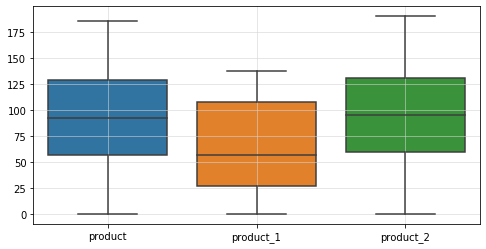

In [7]:
plt.figure(figsize=(8, 4))
boxplt = sns.boxplot(data=regions_product)
boxplt.grid(color='lightgray', alpha=0.7)
plt.show()

In [9]:
# модели линейной регрессии

for i, df in enumerate(regions_data):
    features = df.drop(['product'] , axis=1)
    target = df['product']
    features_train, features_valid, target_train, target_valid = train_test_split(
        features, target, test_size=0.25, random_state=12345)
    
    model = LinearRegression()
    model.fit(features_train, target_train)
    predicted_valid = model.predict(features_valid)
    rmse = mean_squared_error(target_valid, predicted_valid) ** 0.5
    
    print('Регион {}'.format(i))
    print('Средний запас сырья по региону по всем данным: {:.4f}'.format(df['product'].mean()))
    print('Средний запас сырья по региону по предсказанным данным: {:.4f}'.format(predicted_valid.mean()))
    print('RMSE предсказанных данных: {:.4f}'.format(rmse))
    print('-'*40)
    

Регион 0
Средний запас сырья по региону по всем данным: 92.4992
Средний запас сырья по региону по предсказанным данным: 92.4238
RMSE предсказанных данных: 37.7169
----------------------------------------
Регион 1
Средний запас сырья по региону по всем данным: 68.8241
Средний запас сырья по региону по предсказанным данным: 68.9831
RMSE предсказанных данных: 0.8915
----------------------------------------
Регион 2
Средний запас сырья по региону по всем данным: 94.9988
Средний запас сырья по региону по предсказанным данным: 95.1162
RMSE предсказанных данных: 39.9755
----------------------------------------


**Выводы.**

Первое, что хотелось бы отметить - это то, что средние по всем данным и по предсказанным данным почти совпадают.

Второе, запасы сырья в регионах значительно разнятся. Особенно это касается региона №1, в котором средние запасы значительно ниже, чем в других.  
Но в этом регионе метрика RMSE намного ниже, чем в двух других, а значит модель на данных этого региона оказалась лучшей.

***

# 3. Подготовка к расчёту прибыли

Из условий задачи:  
Бюджет на разработку месторождений — 10 млрд рублей, стоимость бурения одной скважины — 50 млн рублей.  
Один баррель сырья приносит 4500 рублей прибыли.  

Исходя из условий задания мы в регионе можем пробурить до 200 скважин. А под минимальным средним объемом сырья, достаточным для его разработки, понимается условия, когда общая прибыль выходит в ноль. Т.е. выручка с объема сырья этих скважин должна быть не ниже затрат на их бурение, а именно - не ниже 10 млрд.руб.  

Таким образом,

**Минимальный объем сырья**: $V_m= 10000000000 / 4500 = 2222222,22$ барелей

In [10]:
# функция по  для расчёта прибыли по набору отобранных месторождений 

def revenue(poins500):
    poins200 = poins500.sort_values(ascending=False)[:200]
    return poins200.sum() * 1000 * 4500 - 10000000000

# 4. Расчёт прибыли и рисков 

Из условий задачи:  
- Для обучения модели подходит только линейная регрессия (остальные — недостаточно предсказуемые).
- При разведке региона проводится исследование 500 точек.  
- Не рассматривать регионы, в которых риск убытков выше 2.5%. Из оставшихся выбирается регион с наибольшей средней прибылью.  

Таким образом, нам нужно для данных каждого региона (которые заранее делим на тренировочные и тестовые) построить модель линейной регрессии, получить предсказанные данные по тестовой выборке, из предсказанных данных техникой Bootstrap с 1000 циклами получить 500 точек и уже их этих 500 выбрать 200 лучших.

In [11]:
state = np.random.RandomState(12345)
regions_profit = {}

for i, df in enumerate(regions_data):
    features = df.drop(['product'] , axis=1)
    target = df['product']
    features_train, features_test, target_train, target_test = train_test_split(
        features, target, test_size=0.25, random_state=state)
    model = LinearRegression()
    model.fit(features_train, target_train)
    predicted_target = pd.Series(model.predict(features_test))

    values = []
    for k in range(1000):
        target_sample = predicted_target.sample(n=500, random_state=state, replace=True)
        values.append(revenue(target_sample))

    regions_profit[i] = values

regions_profit = pd.DataFrame(regions_profit)    
regions_profit.head()

,0,1,2
0,9.434449e+10,9.499439e+10,9.298328e+10
1,9.308703e+10,9.584126e+10,9.296294e+10
2,9.262002e+10,9.083060e+10,9.219969e+10
3,9.355309e+10,9.412181e+10,9.327275e+10
4,9.236064e+10,9.738374e+10,9.367961e+10


In [12]:
for k in regions_profit.columns:
    print('Регион {}'.format(k))
    print("Средняя прибыль: {:,.2f}".format(regions_profit[k].mean()))
    print("95%-ый доверительный интервал: ({:,.2f}, {:,.2f})".
          format(regions_profit[k].quantile(0.025), regions_profit[k].quantile(0.975)))
    print('-'*40)

Регион 0
Средняя прибыль: 93,400,468,596.85
95%-ый доверительный интервал: (91,143,935,686.21, 95,634,997,120.83)
----------------------------------------
Регион 1
Средняя прибыль: 94,556,464,582.00
95%-ый доверительный интервал: (90,630,542,382.98, 98,646,529,461.36)
----------------------------------------
Регион 2
Средняя прибыль: 93,000,276,340.15
95%-ый доверительный интервал: (91,062,416,301.66, 95,039,626,350.97)
----------------------------------------


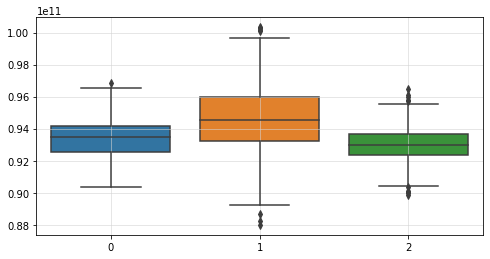

In [13]:
plt.figure(figsize=(8, 4))
boxplt = sns.boxplot(data=regions_profit)
boxplt.grid(color='lightgray', alpha=0.7)
plt.show()

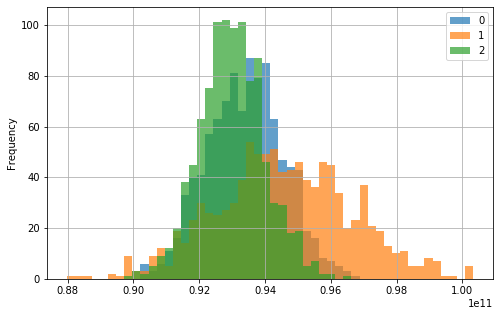

In [14]:
regions_profit.plot(kind='hist', bins=50, grid=True, figsize=(8, 5), alpha=0.7);

In [15]:
count0 = regions_profit[regions_profit[1] > regions_profit[0].mean()][1].count()
print('Кол-во значений, превышающих среднее значение из региона 0:', count0)
count2 = regions_profit[regions_profit[1] > regions_profit[2].mean()][1].count()
print('Кол-во значений, превышающих среднее значение из региона 2:', count2)
count_0 = regions_profit[regions_profit[1] > regions_profit[0].quantile(0.975)][1].count()
print('Кол-во значений, превышающих верхнюю границу региона 0:', count_0)
count_2 = regions_profit[regions_profit[1] > regions_profit[2].quantile(0.975)][1].count()
print('Кол-во значений, превышающих верхнюю границу региона 2:', count_2)


Кол-во значений, превышающих среднее значение из региона 0: 725
Кол-во значений, превышающих среднее значение из региона 2: 777
Кол-во значений, превышающих верхнюю границу региона 0: 311
Кол-во значений, превышающих верхнюю границу региона 2: 406


**Выводы.**  

Из полученных результатов можно сделать вывод, что убыточных регионов нет.  

Что касается средней прибыли по региону, то здесь наилучшие показатели у региона №1, не смотря на то, что в этом регионе средние запасы меньше, чем в других регионах.  

С другой стороны, для данного региона наблюдается значительный разброс результатов. Разность между верхней и нижней границами 95%го доверительного интервала в этом регионе составляет более 8 млрд.руб., тогда как в других регионах только 4, а нижняя граница этого интервала в регионе №1 ниже, чем в других регионах.  

Но даже при этом регион №1 предпочтительней двух других!
Среднее значение прибыли по этому региону близко к верхней границе доверительных интервалов двух других регионов. На показанной выше гистограмме и вычесленных данных видно, что почти 3/4 всех значений этого региона больше средних значений двух других регионов, а треть значений - выше верхних границ доверительного интервала тех регионов.